In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.linalg import expm
%matplotlib inline

Here we perform a continuous time quantum walk (CTQW) on a complete graph with four nodes (denoted as $K_4$). We will be following [this](https://www.nature.com/articles/ncomms11511) paper.

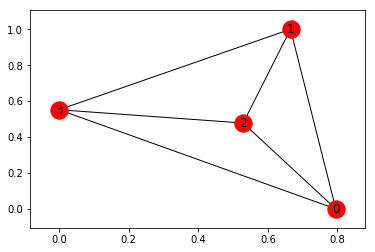

In [2]:
G = nx.complete_graph(4)
nx.draw_networkx(G)

The spectrum of complete graphs is quite simple -- one eigenvalue equal to $N-1$ (where $N$ is the number of nodes) and the remaining equal to -1:

In [3]:
A = nx.adjacency_matrix(G).toarray()
eigvals, _ = np.linalg.eigh(A)
print(eigvals)

[-1. -1. -1.  3.]


For the CTQW the usual hamiltonian is the adjacency matrix $A$. We modify it slightly by adding the identity, i.e. we take $\mathcal{H} = A + I$. This will reduce the number of gates we need to apply, since the eigenvectors with 0 eigenvalue will not acquire a phase.

In [4]:
hamil = A + np.eye(4)

It turns out that $K_n$ graphs are Hadamard diagonalizable, allowing us to write $\mathcal{H} = Q \Lambda Q^\dagger$, where $Q = H \otimes H$. Let's check that this works.

In [5]:
had = np.sqrt(1/2) * np.array([[1, 1], [1, -1]])
pauli_x = np.array([[0, 1], [1, 0]])
Q = np.kron(had, had)
Q.conj().T.dot(hamil).dot(Q)

array([[  4.00000000e+00,   0.00000000e+00,  -9.86076132e-32,
          0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00]])

The time evolution operator $e^{-iHt}$ is also diagonalized by the same transformation. In particular we have

$$
Q^\dagger e^{-iHt}Q = \begin{pmatrix} 
            e^{-i4t} & 0 & 0 & 0 \\
            0 & 1 & 0 & 0 \\
            0 & 0 & 1 & 0 \\
            0 & 0 & 0 & 1
           \end{pmatrix}
$$

Which is just a [CPHASE00](http://pyquil.readthedocs.io/en/latest/gates.html) gate with an angle of $-4t$. The circuit to simulate these is then extremely simple:

![](circuit.png "Circuit for $K_4$ CTQW")

(Taken from paper above, $\gamma = 1$ in our case.)

In [6]:
import pyquil.quil as pq
import pyquil.api as api
from pyquil.gates import H, X, CPHASE00

In [7]:
qvm = api.SyncConnection()

In [8]:
def k_4_ctqw(t):
    p = pq.Program()
    
    #   Change to diagonal basis
    p.inst(H(0))
    p.inst(H(1))
    p.inst(X(0))
    p.inst(X(1))
    
    #    Time evolve
    p.inst(CPHASE00(-4*t, 0, 1))
    
    #   Change back to computational basis
    p.inst(X(0))
    p.inst(X(1))
    p.inst(H(0))
    p.inst(H(1))
    
    return p

Let's compare the quantum walk with a classical random walk. The classical time evolution operator is $e^{-(\mathcal{T} - I) t}$ where $\mathcal{T}$ is the transition matrix of the graph.

We choose as our initial condition $|\psi(0)> = |0>$, that is the walker starts on the first node. Therefore, due to symmetry, the probability of occupation of all nodes besides $| 0 >$ is the same. 

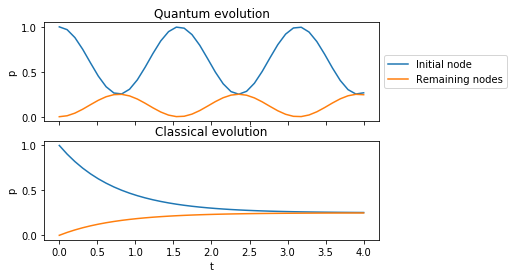

In [9]:
T = A/np.sum(A, axis=0)
time = np.linspace(0, 4, 40)
quantum_probs = np.zeros((len(time), 4))
classical_probs = np.zeros((len(time), 4))

for i, t in enumerate(time):
    p = k_4_ctqw(t)  
    wvf, _ = qvm.wavefunction(p)
    vec = wvf.amplitudes
    quantum_probs[i] = np.abs(vec)**2

    classical_ev = expm((T-np.eye(4))*t)
    classical_probs[i] = classical_ev[:, 0]    
    
f, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=True)

ax1.set_title("Quantum evolution")
ax1.set_ylabel('p')
ax1.plot(time, quantum_probs[:, 0], label='Initial node')
ax1.plot(time, quantum_probs[:, 1], label='Remaining nodes')
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax2.set_title("Classical evolution")
ax2.set_xlabel('t')
ax2.set_ylabel('p')
ax2.plot(time, classical_probs[:, 0], label='Initial node')
ax2.plot(time, classical_probs[:, 1], label='Remaining nodes')

As expected the quantum walk exhbits coherent oscillations whilst the classical walk converges to the stationary distribution $p_i = \frac{d_i}{\sum_j d_j} = \frac{1}{4}$.

We can readily generalize this scheme to any $K_{2^n}$ graphs.

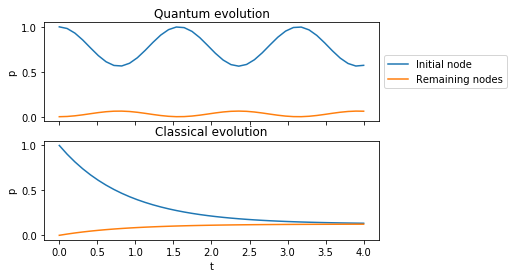

In [10]:
def k_2n_ctqw(n, t):
    p = pq.Program()
    
    #    Change to diagonal basis
    for i in range(n):
        p.inst(H(i))
        p.inst(X(i))

    #   Create and apply CPHASE00
    big_cphase00 = np.diag(np.ones(2**n)) + 0j
    big_cphase00[0, 0] = np.exp(-1j*4*t)
    p.defgate("BIG-CPHASE00", big_cphase00)     
    args = tuple(["BIG-CPHASE00"] + list(range(n)))
    p.inst(args)

    #   Change back to computational basis
    for i in range(n):
        p.inst(X(i))
        p.inst(H(i))
    
    return p

def k_2n_crw(n, t):
    G = nx.complete_graph(2**n)
    A = nx.adjacency_matrix(G)
    T = A/np.sum(A, axis=0)
    classical_ev = expm((T-np.eye(2**n))*t)
    
    return classical_ev[:, 0]    

time = np.linspace(0, 4, 40)
quantum_probs = np.zeros((len(time), 8))
classical_probs = np.zeros((len(time), 8))

for i, t in enumerate(time):
    p = k_2n_ctqw(3, t)  
    wvf, _ = qvm.wavefunction(p)
    vec = wvf.amplitudes
    quantum_probs[i] = np.abs(vec)**2
    classical_probs[i] = k_2n_crw(3, t)  
    
f, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=True)

ax1.set_title("Quantum evolution")
ax1.set_ylabel('p')
ax1.plot(time, quantum_probs[:, 0], label='Initial node')
ax1.plot(time, quantum_probs[:, 1], label='Remaining nodes')
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax2.set_title("Classical evolution")
ax2.set_xlabel('t')
ax2.set_ylabel('p')
ax2.plot(time, classical_probs[:, 0], label='Initial node')
ax2.plot(time, classical_probs[:, 1], label='Remaining nodes')